## SUBMISSION FOR HACKATHON_2 

I have used and Implemented **cDCGAN** for generating images of Alphabets <br/><br/> Considering the size of the training dataset and our computational capability, **batchsize_size = 0** , **Epochs = 50**
<br/> Epochs could be increased for better results but as it was taking too long i have just shown results for 30 epochs

## IMPORTING LIBRARIES

Implementation is done using PyTorch. <br/> I have used the my previous submission of hackathon for Refrence of some part of code with some relevant changes according to our dataset

In [1]:
import numpy as np
import numpy as np
import random
from PIL import Image
import PIL.ImageOps
import os
import shutil
import matplotlib
# matplotlib.use("TKAgg")
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import shutil
from PIL import Image

# CREATING DATASET 

Since we had an unlabeled dataset, we proceeded in following steps below<br/> 
<ul>
<li>Noticed the pattern in the dataset </li>
<li>Renamed the images to image_{num}</li>
<li>Divided and stored the respective alphabets into their folders</li>
</ul> 

In [2]:
# source_dir = r'C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_2_Dataset\img'
# output_dir = r'C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_2_Dataset'



# for i,image_name in enumerate(os.listdir(source_dir)):

#     folder_number = chr(65 + i % 26)

#     folder_path = os.path.join(output_dir, f'folder_{folder_number}')
#     os.makedirs(folder_path, exist_ok=True)

#     source_path = os.path.join(source_dir, f'image_{i}.png')
#     destination_path = os.path.join(folder_path, f'image_{i}.png')
#     shutil.move(source_path, destination_path)


In [3]:
# path = r"C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_2_Dataset\img"
# num_classes = 26
# image_size = 32

# label_encoder = {i: torch.eye(num_classes)[i] for i in range(num_classes)}

# transform= transforms.Compose([
#                                # Here i have added two lines of code since our dataset had images of 36*36 pixels
#                                # We are resizing it to 64*64, as the original paper had images of 64*64 in it.
#                                transforms.Resize(image_size),
#                                transforms.CenterCrop(image_size),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,),(0.5,))
#                            ])

# full_dataset = []
# for i in range(1716):
#     alphabet_index = i % 26
    
#     image_path = os.path.join(path, f'image_{i}.png')
#     image = transform(Image.open(image_path))
#     label = torch.tensor(alphabet_index)
#     one_hot_label = label_encoder[alphabet_index]
#     full_dataset.append((image, label, one_hot_label))

# CLASS FOR ALPHABET

In [4]:

class AlphabetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            class_images = [os.path.join(class_path, img_name) for img_name in os.listdir(class_path)]
            self.images.extend(class_images)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
       img_path = self.images[idx]
       class_name = os.path.basename(os.path.dirname(img_path))
       class_idx = self.class_to_idx[class_name]
       image = Image.open(img_path)

       if self.transform:
        image = self.transform(image)

       return image, class_idx


transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

dataset = AlphabetDataset(root_dir=r'C:\Users\Trijal Srivastava\OneDrive\Desktop\VS CODE\Hackathon GDIS\Hackathon_2_Dataset_final', transform=transform)

dataloader = DataLoader(dataset, batch_size=66, shuffle=True)


# Generator
For training used :
<ul>
<li>ReLu</li>
<li>Batch Normalisation</li>
<li>Tanh</li>
Also used one hot encoding for input labels.

In [5]:
batch_size=66

nc = 1

nz = 100

ngf = 64

ndf = 64

num_epochs = 30

lr = 0.0002

beta1 = 0.5

num_classes = 26

In [6]:
def weights_init(m):
    #takes class name of m as input
    classname = m.__class__.__name__
    # if its a conv layer initialise weights accordingly
    if classname.find('Conv')!=-1:
        nn.init.normal_(m.weight.data, 0.0,0.02)
    # if its a batchnorm layer initialise weights accordingly
    elif classname.find('BatchNorm')!= -1:
        nn.init.normal_(m.weight.data, 1.0,0.02)
        #bias terms are set to 0
        nn.init.constant_(m.bias.data,0)

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = nn.Sequential(

            nn.ConvTranspose2d(nz +num_classes, ngf*8,4,1,0,bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            # 512*4*4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 256*8*8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 128*16*16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 64*32*32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 3*64*64`
        )

    def forward(self, input,labels):
      one_hot_labels = F.one_hot(labels, num_classes=26).float()
      x = torch.cat([input, one_hot_labels.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, input.size(2), input.size(3))], 1)
      return self.main(x)

In [8]:
netG = Generator()

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(126, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator
For training used :
<ul>
<li>   LeakyReLu </li>
<li>   Batch Normalisation </li>
<li>   Sigmoid </li>
</ul>
At last concatenated

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.main = nn.Sequential(

            nn.Conv2d(1 + num_classes, ndf, 4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # 64*32*32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 128*16*16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 256*8*8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 512*4*4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # Final output is a single integer on which sigmoid is applied
            nn.Sigmoid()
        )

    def forward(self, input, labels):
          one_hot_labels = F.one_hot(labels, num_classes=26).float()
          x = torch.cat([input, one_hot_labels.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, input.size(2), input.size(3))], 1)
          return self.main(x)

In [10]:
netD = Discriminator()
netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(27, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [11]:
criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))


fixed_noise = torch.randn(64, nz, 1,1)
fixed_class_labels = 0

# TRAINING LOOP

In [12]:
# Assuming you have defined num_epochs and dataloader earlier
G_losses = []
D_losses = []
img_list = []
iters = 0
for epoch in range(num_epochs):
    for i, (real_images, class_labels) in enumerate(dataloader):

        netD.zero_grad()

        # Forward pass real batch through D
        output = netD(real_images, class_labels)
        label = torch.full_like(output, 1)  # Real label
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake batch with G
        noise = torch.randn(batch_size, nz, 1, 1)
        fake_images = netG(noise, class_labels)

        # Forward pass fake batch through D
        output = netD(fake_images.detach(), class_labels)
        label.fill_(0)  # Fake label
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()


        netG.zero_grad()

        output = netD(fake_images, class_labels)
        label.fill_(1)  # Fake labels are real for generator cost
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()

        optimizerG.step()

        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        #   with torch.no_grad():
        #     fake = netG(fixed_noise, fixed_class_labels) # Generate fake images with labels
        #   img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        # iters += 1

[0/30][0/26]	Loss_D: 1.4871	Loss_G: 0.8937	D(x): 0.4356	D(G(z)): 0.4238 / 0.5411
[0/30][1/26]	Loss_D: 1.7083	Loss_G: 3.0033	D(x): 0.9429	D(G(z)): 0.7082 / 0.0721
[0/30][2/26]	Loss_D: 0.7521	Loss_G: 3.1894	D(x): 0.6883	D(G(z)): 0.1750 / 0.1324
[0/30][3/26]	Loss_D: 0.4998	Loss_G: 3.1040	D(x): 0.8103	D(G(z)): 0.1739 / 0.0726
[0/30][4/26]	Loss_D: 0.2830	Loss_G: 3.1760	D(x): 0.9111	D(G(z)): 0.1538 / 0.0580
[0/30][5/26]	Loss_D: 0.1920	Loss_G: 3.6874	D(x): 0.9636	D(G(z)): 0.1362 / 0.0335
[0/30][6/26]	Loss_D: 0.1311	Loss_G: 4.1920	D(x): 0.9573	D(G(z)): 0.0789 / 0.0196
[0/30][7/26]	Loss_D: 0.1035	Loss_G: 4.1016	D(x): 0.9492	D(G(z)): 0.0456 / 0.0222
[0/30][8/26]	Loss_D: 0.0923	Loss_G: 3.9969	D(x): 0.9637	D(G(z)): 0.0512 / 0.0207
[0/30][9/26]	Loss_D: 0.0841	Loss_G: 4.2263	D(x): 0.9822	D(G(z)): 0.0619 / 0.0165
[0/30][10/26]	Loss_D: 0.0662	Loss_G: 4.4179	D(x): 0.9769	D(G(z)): 0.0408 / 0.0139
[0/30][11/26]	Loss_D: 0.0613	Loss_G: 4.4552	D(x): 0.9752	D(G(z)): 0.0346 / 0.0140
[0/30][12/26]	Loss_D: 0.07

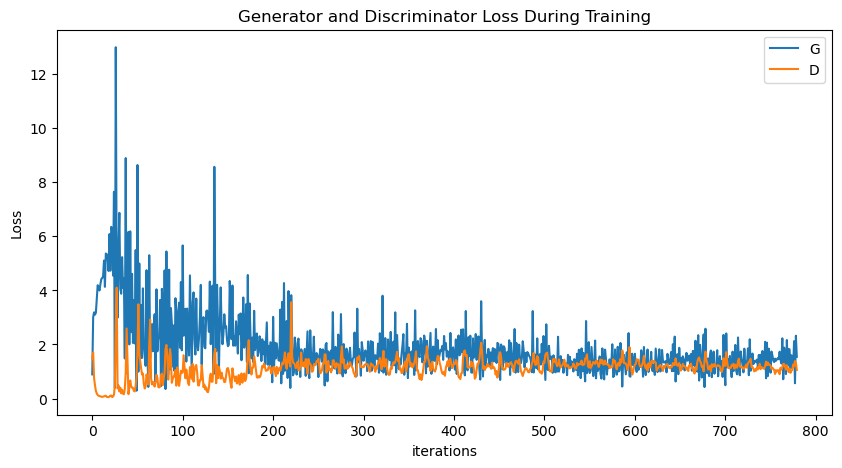

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# CUSTOM CLASS FOR TAKING INPUTS

Here You can input any alphabet you want as output and can pair it up with the random noise vector you want by changing the values of variable **alphabet** and **noise** 

In [26]:
 
fixed_class_label = torch.tensor([25])
fixed_noise = torch.randn(1, nz, 1, 1)


 

# Generate fake images
with torch.no_grad():
    

    # Generate fake images
    fake_images = netG(fixed_noise, fixed_class_label)

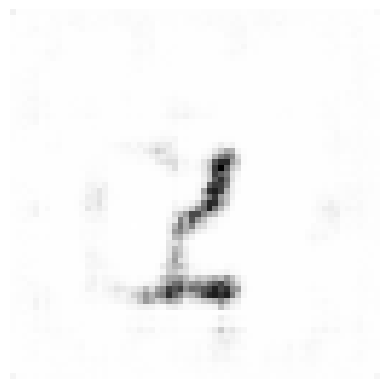

In [27]:
fake_grid = vutils.make_grid(fake_images, padding=2, normalize=True)

# Display the grid
plt.imshow(fake_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()
 







In [18]:
torch.save(netG.state_dict(), 'generator_checkpoint.pth')
